# Fine-tuning of Phi-3.5-mini instruct LLM model

This training pipeline is largely inspired by the Unsloth training notebook for conversational finetunes. Check the reference material from Unsloth here: [LINK](https://colab.research.google.com/drive/1lN6hPQveB_mHSnTOYifygFcrO8C1bxq4?usp=sharing#scrollTo=2eSvM9zX_2d3).

In [1]:
## kaggle installation below

In [2]:
# %%capture
# !pip install pip3-autoremove
# !pip-autoremove torch torchvision torchaudio -y
# !pip install torch torchvision torchaudio xformers --index-url https://download.pytorch.org/whl/cu121
# !pip install unsloth

In [3]:
## colab installation below

In [4]:
%%capture
!pip install unsloth
# Also get the latest nightly Unsloth!
# !pip uninstall unsloth -y && pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git

**NOTES**

Prerequisites:
- `huggingface_hub` is installed. This is useful when downloading snapshots of the training from the HuggingFace for exploration and testing.

Also, directly loading the lora parameters when uploaded to HF does not seem to work. The work around is the pull the HF repo, download the artifacts, and point to that directory when using `FastLanguageModel.from_pretrained`.


In [5]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048  # Choose any! We auto support RoPE Scaling internally!
dtype = (
    None  # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
)
load_in_4bit = True  # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",  # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",  # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit",  # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",  # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",  # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",  # Gemma 2x faster!
]  # More models at https://huggingface.co/unsloth

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!


In [6]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="unsloth/Phi-3.5-mini-instruct",
    max_seq_length=max_seq_length,
    dtype=dtype,
    load_in_4bit=load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

==((====))==  Unsloth 2025.3.15: Fast Llama patching. Transformers: 4.48.3.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.741 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 7.5. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [7]:
model = FastLanguageModel.get_peft_model(
    model,
    r=16,  # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules=[
        "q_proj",
        "k_proj",
        "v_proj",
        "o_proj",
        "gate_proj",
        "up_proj",
        "down_proj",
        # "lm_head",
    ],
    lora_alpha=16,
    lora_dropout=0,  # Supports any, but = 0 is optimized
    bias="none",  # Supports any, but = "none" is optimized
    # [NEW] "unsloth" uses 30% less VRAM, fits 2x larger batch sizes!
    use_gradient_checkpointing="unsloth",  # True or "unsloth" for very long context
    random_state=3407,
    use_rslora=False,  # We support rank stabilized LoRA
    loftq_config=None,  # And LoftQ
)

Unsloth 2025.3.15 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


<a name="Data"></a>
### Data Prep
We now use the `Phi-3` format for conversation style finetunes. We use [Open Assistant conversations](https://huggingface.co/datasets/philschmid/guanaco-sharegpt-style) in ShareGPT style. Phi-3 renders multi turn conversations like below:

```
<|user|>
Hi!<|end|>
<|assistant|>
Hello! How are you?<|end|>
<|user|>
I'm doing great! And you?<|end|>

```

**[NOTE]** To train only on completions (ignoring the user's input) read Unsloth's docs [here](https://github.com/unslothai/unsloth/wiki#train-on-completions--responses-only-do-not-train-on-inputs).

We use our `get_chat_template` function to get the correct chat template. We support `zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old` and our own optimized `unsloth` template.

Note ShareGPT uses `{"from": "human", "value" : "Hi"}` and not `{"role": "user", "content" : "Hi"}`, so we use `mapping` to map it.

For text completions like novel writing, try this [notebook](https://colab.research.google.com/drive/1ef-tab5bhkvWmBOObepl1WgJvfvSzn5Q?usp=sharing).

In [8]:
from unsloth.chat_templates import get_chat_template

tokenizer = get_chat_template(
    tokenizer,
    chat_template="phi-3",  # Supports zephyr, chatml, mistral, llama, alpaca, vicuna, vicuna_old, unsloth
    mapping={
        "role": "from",
        "content": "value",
        "user": "human",
        "assistant": "gpt",
    },  # ShareGPT style
)


def formatting_prompts_func(examples):
    convos = examples["conversations"]
    texts = [
        tokenizer.apply_chat_template(
            convo, tokenize=False, add_generation_prompt=False
        )
        for convo in convos
    ]
    return {
        "text": texts,
    }


pass

# from datasets import load_dataset
# dataset = load_dataset("philschmid/guanaco-sharegpt-style", split = "train")
# dataset = dataset.map(formatting_prompts_func, batched = True,)

### Set Environment Variables, Conversation data for fine tuning.

1. First you need to set your HuggingFace Token in your environment, if you are working locally, via kaggle / colab.
2. Upload the fine tuning dataset that we have generated from the previous task. In here, we uploaded it on colab.

In [9]:
import json
from datasets import Dataset

data_name = "finetune-simpleschema-train"  # uploaded in colab

with open(f"conversation_data_{data_name}.json") as fl:
    conv_dataset = json.load(fl)

valid_conv_dataset = []

with open(f"conversation_data_{data_name.replace('-train', '-valid')}.json") as fl:
    valid_conv_dataset = json.load(fl)

print(len(conv_dataset), len(valid_conv_dataset))


def process_conv_dataset(conv_dataset):
    conv_dataset = [{"conversations": o} for o in conv_dataset]
    conv_dataset = Dataset.from_list(conv_dataset)
    conv_dataset = conv_dataset.map(
        formatting_prompts_func,
        batched=True,
    )

    return conv_dataset


conv_dataset = process_conv_dataset(conv_dataset)
valid_conv_dataset = process_conv_dataset(valid_conv_dataset)

64 8


Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

In [10]:
conv_dataset

Dataset({
    features: ['conversations', 'text'],
    num_rows: 64
})

Let's see how the `Phi-3` format works by printing the 5th element

In [11]:
print(conv_dataset[5]["text"])

<|user|>
2 
1 Introduction 
The mining sector in Africa is growing rapidly and is the main recipient of foreign direct 
investment (World Bank 2011). The welfare effects of this sector are not well understood, 
although a literature has recently developed around this question. The main contribution of this 
paper is to shed light on the welfare effects of gold mining in a detailed, in-depth country study 
of Ghana, a country with a long tradition of gold mining and a recent, large expansion in capital-intensive and industrial-scale production. 
A second contribution of this paper is to show the importance of decomposing the effects with 
respect to distance from the mines. Given the spatial heterogeneity of the results, we explore 
the effects in an individual-level, difference-in-differences analysis by using spatial lag models 
to allow for nonlinear effects with distance from mine. We also allow for spillovers across 
districts, in a district-level analysis. We use two complementary

### Some Statistics

In [12]:
# Token count to the conv_dataset features


def count_tokens(example):
    return {"num_tokens": len(tokenizer.encode(example["text"]))}


conv_dataset = conv_dataset.map(count_tokens)
valid_conv_dataset = valid_conv_dataset.map(count_tokens)
conv_dataset

Map:   0%|          | 0/64 [00:00<?, ? examples/s]

Map:   0%|          | 0/8 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'text', 'num_tokens'],
    num_rows: 64
})

Rate of observations with data mention: 0.296875


<Axes: >

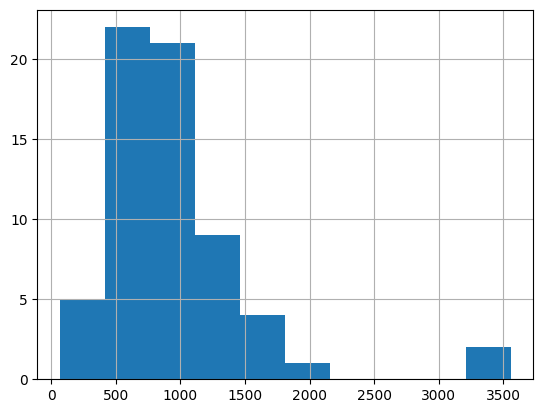

In [13]:
import pandas as pd
import numpy as np

# print("Rate of observations with data mention:", np.mean([json.loads(c[-1]["value"])["data_detected"] for c in conv_dataset["conversations"]]))
print(
    "Rate of observations with data mention:",
    np.mean(
        [json.loads(c[-1]["value"])["data_used"] for c in conv_dataset["conversations"]]
    ),
)

pd.Series(conv_dataset["num_tokens"]).hist()

In [14]:
# Filter data beyond 4096 tokens
conv_dataset = conv_dataset.filter(lambda x: x["num_tokens"] < max_seq_length)
valid_conv_dataset = valid_conv_dataset.filter(
    lambda x: x["num_tokens"] < max_seq_length
)
conv_dataset

Filter:   0%|          | 0/64 [00:00<?, ? examples/s]

Filter:   0%|          | 0/8 [00:00<?, ? examples/s]

Dataset({
    features: ['conversations', 'text', 'num_tokens'],
    num_rows: 61
})

Rate of observations with data mention: 0.2786885245901639


<Axes: >

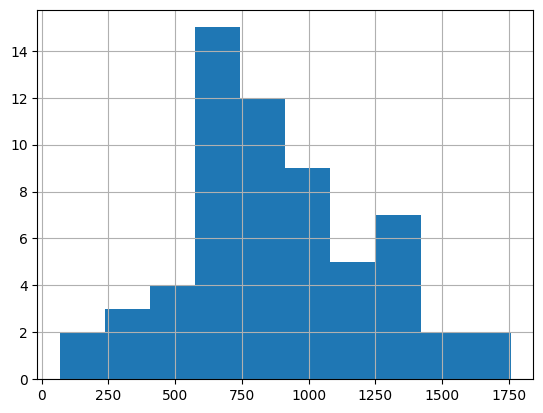

In [15]:
print(
    "Rate of observations with data mention:",
    np.mean(
        [json.loads(c[-1]["value"])["data_used"] for c in conv_dataset["conversations"]]
    ),
)
pd.Series(conv_dataset["num_tokens"]).hist()

If you're looking to make your own chat template, that also is possible! You must use the Jinja templating regime. We provide our own stripped down version of the `Unsloth template` which we find to be more efficient, and leverages ChatML, Zephyr and Alpaca styles.

More info on chat templates on [our wiki page!](https://github.com/unslothai/unsloth/wiki#chat-templates)

In [16]:
unsloth_template = (
    "{{ bos_token }}"
    "{{ 'You are a helpful assistant to the user\n' }}"
    "{% for message in messages %}"
    "{% if message['role'] == 'user' %}"
    "{{ '>>> User: ' + message['content'] + '\n' }}"
    "{% elif message['role'] == 'assistant' %}"
    "{{ '>>> Assistant: ' + message['content'] + eos_token + '\n' }}"
    "{% endif %}"
    "{% endfor %}"
    "{% if add_generation_prompt %}"
    "{{ '>>> Assistant: ' }}"
    "{% endif %}"
)
unsloth_eos_token = "eos_token"

if False:
    tokenizer = get_chat_template(
        tokenizer,
        chat_template=(
            unsloth_template,
            unsloth_eos_token,
        ),  # You must provide a template and EOS token
        mapping={
            "role": "from",
            "content": "value",
            "user": "human",
            "assistant": "gpt",
        },  # ShareGPT style
        map_eos_token=True,  # Maps <|im_end|> to </s> instead
    )

<a name="Train"></a>
### Train the model
Now let's use Huggingface TRL's `SFTTrainer`! More docs here: [TRL SFT docs](https://huggingface.co/docs/trl/sft_trainer). We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`. We also support TRL's `DPOTrainer`!

### Implement a custom Callback to upload our model to HuggingFace per epoch completed.

In [17]:
from transformers import TrainerCallback
import dataclasses


class PushToHubCallback(TrainerCallback):
    def __init__(
        self,
        repo_name: str,
        save_methods: str | list[str],
        private: bool = True,
        limit_log_history: bool = True,
    ):
        if isinstance(save_methods, str):
            save_methods = [save_methods]

        for sm in save_methods:
            if sm not in ("lora", "merged_16bit"):
                raise ValueError(f"Save method {sm} not known...")

        self.repo_name = repo_name
        self.save_methods = save_methods
        self.private = private
        self.limit_log_history = limit_log_history

    def on_epoch_end(self, args, state, control, model, processing_class, **kwargs):
        sd = dataclasses.asdict(state)

        if self.limit_log_history:
            # Limit the history only to uncommitted states.
            sd["log_history"] = [
                s for s in sd["log_history"] if s["epoch"] > (sd["epoch"] - 1)
            ]

        commit_message = json.dumps(sd)

        for save_method in self.save_methods:
            print(f"Saving model to {self.repo_name}...")

            try:
                model.save_pretrained_merged(
                    f"{self.repo_name}-{save_method}",
                    tokenizer=processing_class,
                    save_method=save_method,
                )
                model.push_to_hub_merged(
                    f"{self.repo_name}-{save_method}",
                    tokenizer=processing_class,
                    save_method=save_method,
                    private=self.private,
                    commit_message=commit_message,
                )
            except Exception as e:
                print(f"Exception: {e}")
                continue


def save_best_model(trainer):
    if trainer.args.load_best_model_at_end:
        # Save best model
        for callback in callbacks:
            if isinstance(callback, PushToHubCallback):
                for sm in callback.save_methods:
                    trainer.model.save_pretrained_merged(
                        f"{callback.repo_name}-{sm}-best",
                        tokenizer=trainer.processing_class,
                        save_method=sm,
                    )

                    trainer.model.push_to_hub_merged(
                        f"{callback.repo_name}-{sm}",
                        tokenizer=trainer.processing_class,
                        save_method=sm,
                        private=callback.private,
                        commit_message="best",
                    )

In [18]:
# https://github.com/NVlabs/tiny-cuda-nn/issues/183
# If there's an error in -lcuda, manually create symbolic link to the libcuda.so in /lib/x86_64-linux-gnu
# sudo ln -s libcuda.so.1 libcuda.so

from datetime import datetime
from unsloth import is_bfloat16_supported

from unsloth import UnslothTrainer, UnslothTrainingArguments

# Set demo flag
demo = True  # Set to False for full training

# Define parameters based on demo flag
if demo:
    n_epochs = 1
    max_steps = 50
    per_device_train_batch_size = 1
    gradient_accumulation_steps = 1
    per_device_eval_batch_size = 1
    eval_accumulation_steps = 1
    eval_steps = 10
    logging_steps = 10
    dataset_num_proc = 1
else:
    n_epochs = 10
    # When not in demo mode, we use epochs and let training run full length.
    # (We do not set max_steps here.)
    per_device_train_batch_size = 4
    gradient_accumulation_steps = 4
    per_device_eval_batch_size = 4
    eval_accumulation_steps = 16
    eval_steps = 100
    logging_steps = 100
    dataset_num_proc = 4

model_name = f"data-use-unsloth-phi-3.5-{data_name}-{n_epochs}epochs-{int(datetime.utcnow().timestamp())}"

callbacks = [
    PushToHubCallback(
        repo_name=model_name,
        save_methods="lora",
        private=True,
        limit_log_history=True,
    )
]

trainer = UnslothTrainer(
    model=model,
    tokenizer=tokenizer,
    train_dataset=conv_dataset,
    eval_dataset=valid_conv_dataset,
    dataset_text_field="text",
    max_seq_length=max_seq_length,
    dataset_num_proc=dataset_num_proc,
    packing=True,  # Use packing to speed up training on short sequences.
    args=UnslothTrainingArguments(
        output_dir=f"./pf-{model_name}",
        embedding_learning_rate=2e-6,
        per_device_train_batch_size=per_device_train_batch_size,
        gradient_accumulation_steps=gradient_accumulation_steps,
        per_device_eval_batch_size=per_device_eval_batch_size,
        eval_accumulation_steps=eval_accumulation_steps,
        eval_strategy="steps",
        eval_steps=eval_steps,
        warmup_ratio=0.01,
        num_train_epochs=n_epochs,
        # Only include max_steps in demo mode.
        **({"max_steps": max_steps} if demo else {}),
        learning_rate=2e-4,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=logging_steps,
        optim="adamw_8bit",
        weight_decay=0.01,
        lr_scheduler_type="linear",
        seed=1029,
        report_to="none",  # Disable external logging (e.g., WandB)
        save_total_limit=2,
        load_best_model_at_end=True,
        metric_for_best_model="eval_loss",
        save_strategy="steps",
        save_steps=eval_steps,
    ),
    callbacks=callbacks,
)

Unsloth: Tokenizing ["text"]:   0%|          | 0/61 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


Unsloth: Tokenizing ["text"]:   0%|          | 0/8 [00:00<?, ? examples/s]

Unsloth: Hugging Face's packing is currently buggy - we're disabling it for now!


In [19]:
import os
from google.colab import userdata

os.environ["HF_TOKEN"] = userdata.get("HF_TOKEN")

In [20]:
# @title Show current memory stats
gpu_stats = torch.cuda.get_device_properties(0)
start_gpu_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
max_memory = round(gpu_stats.total_memory / 1024 / 1024 / 1024, 3)
print(f"GPU = {gpu_stats.name}. Max memory = {max_memory} GB.")
print(f"{start_gpu_memory} GB of memory reserved.")

GPU = Tesla T4. Max memory = 14.741 GB.
2.236 GB of memory reserved.


In [21]:
# https://github.com/NVlabs/tiny-cuda-nn/issues/183
# If there's an error in -lcuda, manually create a symbolic link to the libcuda.so in /lib/x86_64-linux-gnu
# sudo ln -s libcuda.so.1 libcuda.so

trainer_stats = trainer.train()
save_best_model(trainer)

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 61 | Num Epochs = 1 | Total steps = 50
O^O/ \_/ \    Batch size per device = 1 | Gradient accumulation steps = 1
\        /    Data Parallel GPUs = 1 | Total batch size (1 x 1 x 1) = 1
 "-____-"     Trainable parameters = 29,884,416/4,000,000,000 (0.75% trained)


Step,Training Loss,Validation Loss
10,1.758400,1.678107
20,1.483300,1.576952
30,1.402600,1.539881
40,1.456000,1.521550
50,1.037100,1.515652


Unsloth: Will smartly offload gradients to save VRAM!
Saving model to data-use-unsloth-phi-3.5-finetune-simpleschema-train-1epochs-1742309422...
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... Done.
Unsloth: Saving LoRA adapters. Please wait...


README.md:   0%|          | 0.00/600 [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

adapter_model.safetensors:   0%|          | 0.00/120M [00:00<?, ?B/s]

  0%|          | 0/1 [00:00<?, ?it/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

Saved lora model to https://huggingface.co/data-use-unsloth-phi-3.5-finetune-simpleschema-train-1epochs-1742309422-lora
Unsloth: Saving tokenizer... Done.
Unsloth: Saving model... Done.
Unsloth: Saving LoRA adapters. Please wait...


No files have been modified since last commit. Skipping to prevent empty commit.
No files have been modified since last commit. Skipping to prevent empty commit.


Saved lora model to https://huggingface.co/data-use-unsloth-phi-3.5-finetune-simpleschema-train-1epochs-1742309422-lora


### Save Pre-tuned LoRA and push to hf.

In [22]:
# save_model = "data-use-unsloth-phi-3.5-simpleschema-pretune-demo"
# model.save_pretrained(save_model) # Local saving
# tokenizer.save_pretrained(save_model)
# model.push_to_hub(save_model, token = "...") # Online saving
# tokenizer.push_to_hub(save_modeltoken = "...") # Online saving

## Fine Tuning on a Rich Manually Labelled Dataset

If you have a manually labelled dataset, you can fine tune the model using those, in our case, we have manually labelled dataset using [Doccano](https://github.com/doccano/doccano), you can provide your data below to train on your data.

In [23]:
## Uncomment the cells below if you have manually labelled data
# import json
# from datasets import Dataset

# data_name = "<manually-labelled-data-use-train>"

# with open(f"conversation_data_{data_name}.json") as fl:
#     conv_dataset = json.load(fl)

# valid_conv_dataset = []

# with open(f"conversation_data_{data_name.replace('-train', '-valid')}.json") as fl:
#     valid_conv_dataset = json.load(fl)

# print(len(conv_dataset), len(valid_conv_dataset))

# def process_conv_dataset(conv_dataset):
#     conv_dataset = [{"conversations": o} for o in conv_dataset]
#     conv_dataset = Dataset.from_list(conv_dataset)
#     conv_dataset = conv_dataset.map(formatting_prompts_func, batched = True,)

#     return conv_dataset

# conv_dataset = process_conv_dataset(conv_dataset)
# valid_conv_dataset = process_conv_dataset(valid_conv_dataset)

# conv_dataset

In [24]:
# # https://github.com/NVlabs/tiny-cuda-nn/issues/183
# # If there's an error in -lcuda, manually create symbolic link to the libcuda.so in /lib/x86_64-linux-gnu
# # sudo ln -s libcuda.so.1 libcuda.so

# from datetime import datetime
# from trl import SFTTrainer
# from transformers import TrainingArguments
# from unsloth import is_bfloat16_supported

# from unsloth import UnslothTrainer, UnslothTrainingArguments

# n_epochs = 20

# model_name = f"data-use-unsloth-phi-3.5-{data_name}-{n_epochs}epochs-{int(datetime.utcnow().timestamp())}"

# callbacks = [
#     PushToHubCallback(
#         repo_name=model_name,
#         save_methods="lora",
#         private=True,
#         limit_log_history=True,
#     )
# ]
# # trainer = SFTTrainer(
# trainer = UnslothTrainer(
#     model = model,
#     tokenizer = tokenizer,
#     train_dataset = conv_dataset,
#     eval_dataset = valid_conv_dataset,
#     dataset_text_field = "text",
#     max_seq_length = max_seq_length,
#     dataset_num_proc = 4,

#     # packing = False, # Can make training 5x faster for short sequences.
#     packing = True, # Can make training 5x faster for short sequences.
#     # args = TrainingArguments(
#     args = UnslothTrainingArguments(
#         output_dir=f"./pf-{model_name}",
#         embedding_learning_rate=2e-6,
#         # per_device_train_batch_size = 4,
#         # gradient_accumulation_steps = 4,
#         per_device_train_batch_size = 2,
#         gradient_accumulation_steps = 1,

#         # Eval
#         per_device_eval_batch_size = 4,
#         eval_accumulation_steps = 16,
#         eval_strategy = "steps",
#         eval_steps = 50,

#         # warmup_steps = 100,
#         warmup_ratio = 0.01,

#         # max_steps = 1000,
#         num_train_epochs=n_epochs,
#         learning_rate = 3e-5,
#         # learning_rate = 2e-4,
#         # learning_rate = 4e-4,
#         # learning_rate = 5e-4,
#         fp16 = not is_bfloat16_supported(),
#         bf16 = is_bfloat16_supported(),
#         logging_steps = 50,
#         optim = "adamw_8bit",
#         weight_decay = 0.01,
#         lr_scheduler_type = "linear",
#         seed = 1029,
#         # output_dir = "outputs",
#         report_to = "none", # Use this for WandB etc

#         save_total_limit=2,
#         load_best_model_at_end=True,
#         metric_for_best_model="eval_loss",
#         save_strategy="steps",
#         save_steps=50,
#     ),
#     callbacks=callbacks,
# )

In [25]:
# # https://github.com/NVlabs/tiny-cuda-nn/issues/183
# # If there's an error in -lcuda, manually create a symbolic link to the libcuda.so in /lib/x86_64-linux-gnu
# # sudo ln -s libcuda.so.1 libcuda.so

# trainer_stats = trainer.train()
# save_best_model(trainer)

In [26]:
# @title Show final memory and time stats
used_memory = round(torch.cuda.max_memory_reserved() / 1024 / 1024 / 1024, 3)
used_memory_for_lora = round(used_memory - start_gpu_memory, 3)
used_percentage = round(used_memory / max_memory * 100, 3)
lora_percentage = round(used_memory_for_lora / max_memory * 100, 3)
print(f"{trainer_stats.metrics['train_runtime']} seconds used for training.")
print(
    f"{round(trainer_stats.metrics['train_runtime']/60, 2)} minutes used for training."
)
print(f"Peak reserved memory = {used_memory} GB.")
print(f"Peak reserved memory for training = {used_memory_for_lora} GB.")
print(f"Peak reserved memory % of max memory = {used_percentage} %.")
print(f"Peak reserved memory for training % of max memory = {lora_percentage} %.")

140.1605 seconds used for training.
2.34 minutes used for training.
Peak reserved memory = 4.271 GB.
Peak reserved memory for training = 2.035 GB.
Peak reserved memory % of max memory = 28.974 %.
Peak reserved memory for training % of max memory = 13.805 %.


<a name="Save"></a>
### Saving finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model.

In [27]:
save_model = "data-use-unsloth-phi-3.5-simpleschema-finetune-demo"
model.save_pretrained(save_model)  # Local saving
tokenizer.save_pretrained(save_model)
# model.push_to_hub(save_model, token = "...") # Online saving
# tokenizer.push_to_hub(save_modeltoken = "...") # Online saving

('data-use-unsloth-phi-3.5-simpleschema-finetune-demo/tokenizer_config.json',
 'data-use-unsloth-phi-3.5-simpleschema-finetune-demo/special_tokens_map.json',
 'data-use-unsloth-phi-3.5-simpleschema-finetune-demo/tokenizer.model',
 'data-use-unsloth-phi-3.5-simpleschema-finetune-demo/added_tokens.json',
 'data-use-unsloth-phi-3.5-simpleschema-finetune-demo/tokenizer.json')